# Predicting stock indices using Long Short Term Memory networks

## Overview

* [Technical indicators](#Technical-indicators)
* [Data setup](#Downloading-cleaning)
* [Basic EDA](#EDA)
* [Model building](#Model-building)
* [Hyperparameter optimization](#Hyperparameter-tuning)
* [Training and vizualizing prediction error](#Training-vizu)
* [Backtesting](#Backtesting)
* [Conclusion](#Conclusion)


### Short introduction

This notebook is a take on using LSTM recurrent neural networks for predicting stock markets in particular European indices. LSTM RNN have shown great success in trying to predict sequence data or timeseries and that is why the framework might be suitable for predicting stock markets. A typical classification problem can either be right or wrong and this is fine when modeling you are just modeling whether something belongs to a class. The issue with stock market predictions is that of course you would like to predict whether the market goes up or down, but also minimize the loss when your prediction is wrong. So the usual evaluation on accuracy is not enough which is were the backtesting becomes important. The model is tested on a index that were not available during training and the true performance is return of investment.  

The data that is used is some of the main indices from Europe but this framework can easily be expanded to include any other index or even be used on individual stock prices. Daily OHLC data from Yahoo Finance is easily accessible. Furthermore the data is enriched with currency exchange rates indices that might have some predictable power on the indices such as EURUSD, EURGBP etc. One of the hypothesis is that a volatility index would also have a predictive power however unfortunately the historical data from VDAX is not available from Yahoo Finance as a proxy we use the VIX, which could a measure of the overall volatility in the global economy and hopefully have some predictive power.

## Packages imports

In [1]:
## Package imports
import os
import datetime
from datetime import timedelta
import time

## The usual suspects
import pandas as pd
import numpy as np

## Visualization tools
%matplotlib inline  
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

## Packages for downloading financial data
import yfinance as yf

## Neural network tools
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

## Bayesian optimization tools
from bayes_opt import BayesianOptimization
from functools import partial

## Set seed for reproduceability
np.random.seed(1)

In [2]:
## Function to time code.
def tic():
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set")
        
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.keras.backend.set_floatx('float64')

physical_devices------------- 1


## Technical indicators as features <a class="anchor" id="Technical-indicators">
Technical indicator is widely used by many practitioners (technical analysis) such as Simple Moving Averages (SMA), Bollinger Bands etc. to predict whether the stock is likely to move up or down. We enrich the data with some of the most common technical indicators SMA, Bollinger Bands, RSI, MACD and Fast Fourier Transforms. It can easily incorporate more indicators if needed

In [3]:
## Setup functions for adding features and format data
def macd(data, a, b):
    return data['Close'].ewm(span=a).mean() - data['Close'].ewm(span=b).mean()

def bollinger_bands(data, flag):
    sma = data['Close'].rolling(window=20).mean()
    smv = data['Close'].rolling(window=20).std()
    if flag == 'Upper':
        return sma + 2 * smv
    elif flag == 'Lower':
        return sma - 2 * smv
    else:
        raise ValueError('Wrong input.')
        
def rsi(data):
    df_ret = data['Close'].pct_change()
    g = df_ret * (df_ret > 0)
    l = df_ret * (df_ret < 0)
    avg_g = g.rolling(window=14).mean()
    avg_l = l.rolling(window=14).mean()
    rs = abs(avg_g.divide(avg_l))
    return 100 * rs / (1 + rs)

def fft_indicator(data, k):
    sp = np.fft.fft(data)
    return abs(np.fft.ifft(sp[:k], len(data)))[-1]

def addFeatures(data):
    sma_days = [10,50,100,200]

    for days in sma_days:
        data.loc[:, 'sma' + str(days)] = data['Close'].rolling(window=days).mean()
        data.loc[:, 'ema' + str(days)] = data['Close'].ewm(span=days).mean()

    data.loc[:, 'MACD'] = macd(data, 12, 26)
    data.loc[:, 'BB_Upper'] = bollinger_bands(data, 'Upper')
    data.loc[:, 'BB_Lower'] = bollinger_bands(data, 'Lower')
    data.loc[:, 'RSI'] = rsi(data)
    
    data.dropna(inplace=True)
    
    #data.loc[:, 'fft3'] = fft_indicator(data,3)
    #data.loc[:, 'fft6'] = fft_indicator(data,6)
    #data.loc[:, 'fft9'] = fft_indicator(data,9)
    data.loc[:, 'fft3'] = data["Close"].rolling(250).apply(lambda x: fft_indicator(x,3))
    data.loc[:, 'fft6'] = data["Close"].rolling(250).apply(lambda x: fft_indicator(x,6))
    data.loc[:, 'fft9'] = data["Close"].rolling(250).apply(lambda x: fft_indicator(x,9))
    
    return data

def nnFormat(data, window=4):
    nrows = data.shape[0]
    ncols = data.shape[1]

    features = np.zeros(shape=(0, window, ncols - 2))
    label1 = np.zeros(shape=(0,1))
    label2 = np.zeros(shape=(0,1))
    
    for i in range(window,nrows-1):
        features = np.append(features, data[i-window:i,0:(ncols-2)].reshape(1, window, ncols - 2), axis=0)
        label1 = np.append(label1, data[i, ncols-2].reshape(1,1), axis=0)
        label2 = np.append(label2, data[i, ncols-1].reshape(1,1), axis=0)
    
    
    return features, label1, label2

## Downloading and cleaning data <a class="anchor" id="Downloading-cleaning">

In [4]:
startDate = '2007-01-02'
endDate = '2020-07-31'

validationDate = '2020-01-01'
testDate = '2020-06-01'

## Download currency data + VIX
curr_vix_list = ['EURUSD=X', 'EURGBP=X', 'EURSEK=X', 'EURJPY=X', 'EURCNY=X', '^VIX']
curr_vix_data = yf.download(curr_vix_list, start=startDate, end=endDate)
curr_vix_data = curr_vix_data['Close']
curr_vix_data = curr_vix_data.rename(columns={"EURUSD=X": "EURUSD", 
                                      "EURGBP=X": "EURGBP", 
                                      "EURSEK=X": "EURSEK", 
                                      "EURJPY=X": "EURJPY",
                                      "EURCNY=X": "EURCNY"})

indices = ['^STOXX50E', '^N100', '^BFX', '^GDAXI', '^FTSE', '^FCHI']
sequence_length = 20

noOfFeatures = 25

trainFeatures = np.zeros(shape=(0, sequence_length, noOfFeatures))
trainLabel1 = np.zeros(shape=(0,1))
trainLabel2 = np.zeros(shape=(0,1))

validationFeatures = np.zeros(shape=(0, sequence_length, noOfFeatures))
validationLabel1 = np.zeros(shape=(0,1))
validationLabel2 = np.zeros(shape=(0,1))

testFeatures = np.zeros(shape=(0, sequence_length, noOfFeatures))
testLabel1 = np.zeros(shape=(0,1))
testLabel2 = np.zeros(shape=(0,1))

scalers = {}

for ind in indices:
    print(ind)
    data = yf.download(ind, start=startDate, end=endDate)
    data = pd.concat([data, curr_vix_data], axis=1)
    data.fillna(method='ffill', inplace=True)
    data.drop(['Volume', 'Adj Close'], axis=1, inplace=True)
    data = addFeatures(data)
    
    data.loc[:, 'Gradient'] = ((data.loc[:, 'Close'] - data.loc[:, 'Close'].shift())/data.loc[:, 'Close'].shift() + 1).shift(-1)
    data.dropna(inplace=True)
    buySell = data.loc[:, 'Gradient'] > 1 
    
    ## Normalizing data
    
    tempScaler = MinMaxScaler()
    tempScaler.fit(data.loc[:testDate])
    norm_data = tempScaler.transform(data.to_numpy())
    norm_data = np.append(norm_data, buySell.astype(int).to_numpy().reshape(len(buySell),1), axis=1)
    
    scalers[ind] = tempScaler
    #norm_data = (stock_data - stock_data.min())/(stock_data.max() - stock_data.min()    
    #norm_data = (data - data.min())/(data.max() - data.min())
    #norm_data.loc[:, 'BuySell'] = buySell.astype(int)
    
    tempFeatures, tempLabel1, tempLabel2 = nnFormat(norm_data,sequence_length)
    
    validationIdx = data.index.get_loc(datetime.datetime.strptime(validationDate, '%Y-%m-%d')) - sequence_length
    testIdx = data.index.get_loc(datetime.datetime.strptime(testDate, '%Y-%m-%d')) - sequence_length
                                    
    trainFeatures = np.append(trainFeatures, tempFeatures[:validationIdx,:,:], axis=0)
    trainLabel1 = np.append(trainLabel1, tempLabel1[:validationIdx,:], axis=0)
    trainLabel2 = np.append(trainLabel2, tempLabel2[:validationIdx,:], axis=0)
    
    validationFeatures = np.append(validationFeatures, tempFeatures[validationIdx:testIdx,:,:], axis=0)
    validationLabel1 = np.append(validationLabel1, tempLabel1[validationIdx:testIdx,:], axis=0)
    validationLabel2 = np.append(validationLabel2, tempLabel2[validationIdx:testIdx,:], axis=0)
                                 
    testFeatures = np.append(testFeatures, tempFeatures[testIdx:,:,:], axis=0)
    testLabel1 = np.append(testLabel1, tempLabel1[testIdx:,:], axis=0)
    testLabel2 = np.append(testLabel2, tempLabel2[testIdx:,:], axis=0)

[*********************100%***********************]  6 of 6 completed
^STOXX50E
[*********************100%***********************]  1 of 1 completed
^N100
[*********************100%***********************]  1 of 1 completed
^BFX
[*********************100%***********************]  1 of 1 completed
^GDAXI
[*********************100%***********************]  1 of 1 completed
^FTSE
[*********************100%***********************]  1 of 1 completed
^FCHI
[*********************100%***********************]  1 of 1 completed


## Basic EDA <a class="anchor" id="EDA">

Just to get a quick feel of how the data behaves we take a look at the German index DAX and the features that is added to the data.

In [5]:
data = yf.download('^GDAXI', start=startDate, progress=False)
data = pd.concat([data, curr_vix_data], axis=1)
data.fillna(method='ffill', inplace=True)
data.drop(['Volume', 'Adj Close'], axis=1, inplace=True)
data = addFeatures(data)

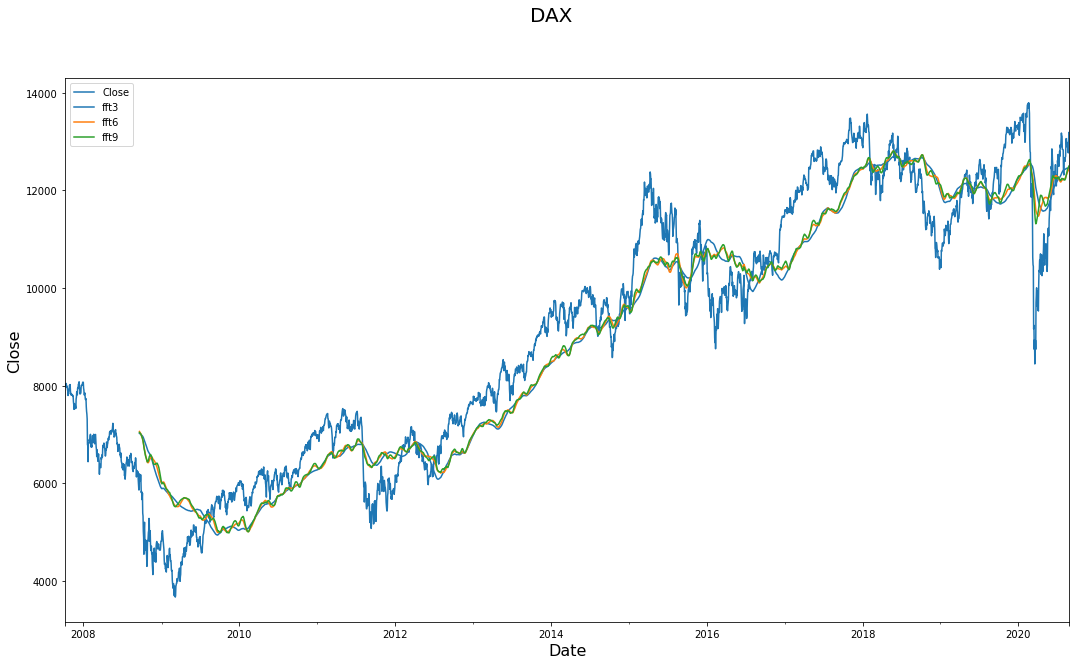

In [6]:
## Plot closing prices
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,10))
fig.suptitle('DAX', fontsize=20)
ax.set_ylabel('Close', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
ax = data['Close'].plot(color=(31/255,119/255,180/255))
ax = data['fft3'].plot()
ax = data['fft6'].plot()
ax = data['fft9'].plot()
ax.legend();

Data since 2007-01-01 is included to have the latest financial crisis in the data and the reason for not taking all data available is that you could argue that algorithmic trading have gone up significantly over the last couple of years and have changed the way stocks and indices are being traded. This is what one would like to capture in a model and not how stocks were traded let's say 20 years ago.

Two of the most common indicators (sma50 and sma200) have been depicted along side the historical and many more have been added as features. 6 different indicators is used in this model but with different parameters making it so that total of 15 extra features are added to the OHLC data.  

Next lets take a look at the correlation between the features in the model.

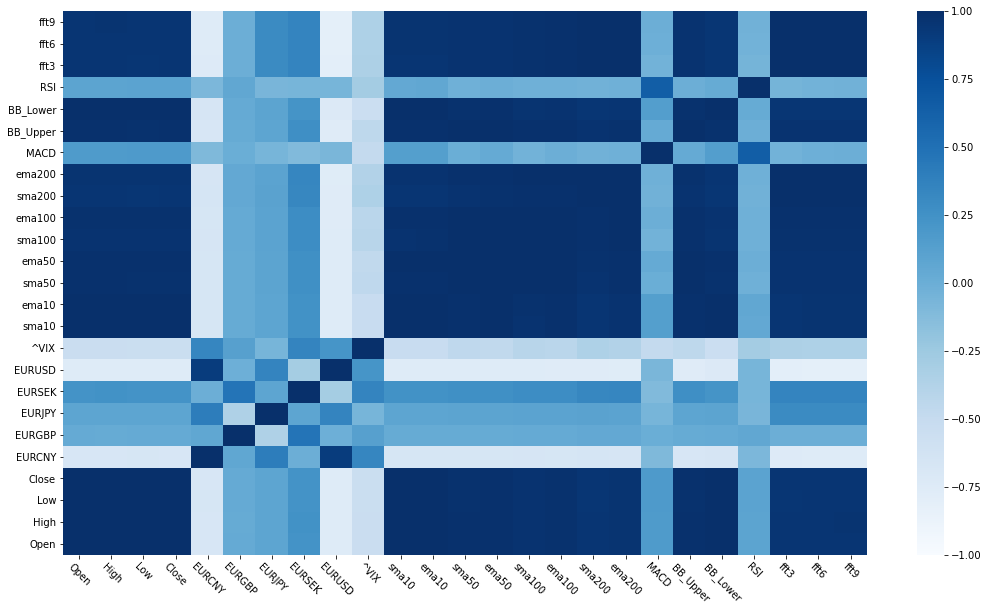

In [7]:
## Correlation plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,10))
sn.heatmap(data.corr(), cmap='Blues', ax=ax, vmin=-1, vmax=1)
ax.tick_params(axis='x', rotation=-45)
ax.invert_yaxis()

The correlation is set between -1 to 1 where 1 corresponds with perfect positive correlation i.e. if the close price goes up the feature also goes up in the similar fashion and -1 is then given by the opposite. As we would expect some of the simple features that is based on the close price have a close correlation with the close price. Remember the task is basically to predict the next close price. 

## Train-Val-Test-Split

The split is done randomly from the dataset. So that every 20 length sequence with corresponding label is a independent observation. This however can be a problem when we look at the generalization error as the the model have been exposed to data points around the test set that is shared for training examples and test example because the each data point consist of a sequence of 20 days. You could instead base the validation set and training set on the dates such that newer data is the validation and test set respectively. The last section in this notebook a backtesting with an index that the model never has seen before is performed to see how well the model performs in terms of return.

## Model building <a class="anchor" id="Model-building">
    
Different layouts for the model have been tried ending with a dual output LSTM model. The main idea of this model is to predict whether the index goes up or down the following period the intuitive way is to see this only as a classification problem but some problems may arise from this. If model is solely based on classification it is not penalized how far the model is from the actual change. This can result in that when the model makes a wrong prediction the loss can much higher than gain when the prediction is on point and the model is only evaluated on how if the price goes up or down. Which is why the model is built such that it also tries to predict the change in the index. Giving us a model that both minimizes the binary crossentropy on the classification problem and a mean squared error on prediction of the change in the index.
    
One thing to be aware of when using LSTM is that the gradient can explode which is why clipping the gradient is used. Here we use keras implementation with the clipnorm. As a regularizer we use the simple dropout technique and treat learning rate, clipnorm dropout rate and layers in the LSTM and dense layer as hyperparameters to be optimized. For the dense layer just before the sigmoid layer the scaled exponential linear unit is used. 

In [8]:
## Model building
def get_model(input_shape, 
              lstm_layer_1_nodes,
              lstm_layer_2_nodes,
              dense_layer_nodes,
              dropout_rate):
    
    input_layer = Input(shape=input_shape, name='Input_Layer')
    
    lstm_layer_1 = LSTM(lstm_layer_1_nodes, 
                        dropout = dropout_rate, 
                        return_sequences=True, 
                        name='First_LSTM_Layer')(input_layer)
    
    lstm_layer_2 = LSTM(lstm_layer_2_nodes, 
                        dropout = dropout_rate,
                        name='Second_LSTM_Layer')(lstm_layer_1)
    
   
    dense_layer_1 = Dense(dense_layer_nodes, 
                          activation='selu', 
                          name='First_Dense_Layer')(lstm_layer_2)
    
    output_layer_1 = Dense(1,
                          activation=None,
                          name='Gradient_Prediction')(lstm_layer_2)
    
    output_layer_2 = Dense(1,
                          activation='sigmoid',
                          name='BuySell_Prediction')(dense_layer_1)

    lstm_model = Model(input_layer, [output_layer_1, output_layer_2])
    
    
    return lstm_model

def fit_model(input_shape,
              lstm_nodes,
              dense_nodes,
              dropout_rate,
              lr,
              batch_size,
              clipnorm,
              loss_weight):

    lstm_model = get_model(input_shape, 
                           int(lstm_nodes),
                           int(lstm_nodes),
                           int(dense_nodes),
                           dropout_rate)
    
    opt = Adam(lr=lr, clipnorm=clipnorm)
    
    loss = {
    'Gradient_Prediction': 'mean_squared_error',
    'BuySell_Prediction': 'binary_crossentropy'
    }

    metrics = {
        'BuySell_Prediction': 'accuracy'
    }
    
    ## Loss_weight emphazising which loss should be weighted the most. [0-1]
    ## loss_weight close to 1 the forecasting is weigthed higher
    ## Loss_weights close to 0 the accuracy is weighted higher
    lstm_model.compile(optimizer=opt,
                      loss=loss,
                      metrics=metrics,
                      loss_weights=[loss_weight, 1-loss_weight])
    
    mcp = ModelCheckpoint(checkpoint_path, 
                          monitor='val_loss', 
                          mode='min', 
                          save_best_only=True,
                          save_weights_only=True)
    
    lstm_model.fit(trainFeatures, [trainLabel1, trainLabel2],
                   epochs=1000,
                   batch_size=int(batch_size),
                   validation_data = [validationFeatures, {'Gradient_Prediction': validationLabel1,
                                                            'BuySell_Prediction': validationLabel2}],
                   callbacks=[mcp],
                   verbose=0)
    
    lstm_model.load_weights('baysianOpt/cp.ckpt')
    
    score = lstm_model.evaluate(validationFeatures, [validationLabel1, validationLabel2], verbose=0)

    return score[3]

## Hyperparameter tuning <a class="anchor" id="Hyperparameter-tuning">
    
As stated above the parameters for tuning is the learning rate, clipnorm, the dropout rate for the lstm layers and then the nodes in the lstm layers and the dense layer. For this an implementation of baysian optimization is used. The baysian optimization makes the tuning of the hyperparameter into a new optimization problem meaning that hopefully the model does not have to go through to many iterations before a set of optimal or near optimal hyperparameters can be chosen to fully train the model. Because training a neural network can be computationally taxing the baysian optimization is done on 250 epochs with early stopping. Evaluating the performance of the model on the combined loss of the model.

In [9]:
## Baysian optimization

checkpoint_path = 'baysianOpt/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

fit_model_partial = partial(fit_model, (trainFeatures.shape[1], trainFeatures.shape[2]), batch_size=4096, loss_weight=0.5)

tic()
pbounds = {'dropout_rate': (0.1, 0.35), 
           'lr': (1e-5, 1e-2),
           'clipnorm':(0.5,1.5),
           'lstm_nodes':(50,100),
           'dense_nodes':(50,100)}

optimizer = BayesianOptimization(
    f=fit_model_partial,
    pbounds=pbounds,
    verbose=2,
    random_state=1
)

optimizer.maximize(init_points=5, n_iter=5)

baysianOptimum = optimizer.max

toc()

|   iter    |  target   | clipnorm  | dense_... | dropou... |    lr     | lstm_n... |
-------------------------------------------------------------------------------------
|  1        |  0.5417   |  0.917    |  86.02    |  0.1      |  0.00303  |  57.34    |
|  2        |  0.534    |  0.5923   |  59.31    |  0.1864   |  0.003974 |  76.94    |
|  3        |  0.5494   |  0.9192   |  84.26    |  0.1511   |  0.008782 |  51.37    |
|  4        |  0.5756   |  1.17     |  70.87    |  0.2397   |  0.001412 |  59.91    |
|  5        |  0.5463   |  1.301    |  98.41    |  0.1784   |  0.006926 |  93.82    |
|  6        |  0.5849   |  0.7501   |  50.08    |  0.1537   |  0.003541 |  50.39    |
|  7        |  0.5386   |  1.483    |  79.28    |  0.1494   |  0.00652  |  99.64    |
|  8        |  0.571    |  0.5455   |  62.81    |  0.2454   |  0.001618 |  50.04    |
|  9        |  0.5324   |  1.461    |  50.92    |  0.3354   |  0.005693 |  99.44    |
|  10       |  0.5448   |  1.223    |  53.36    |  0.2

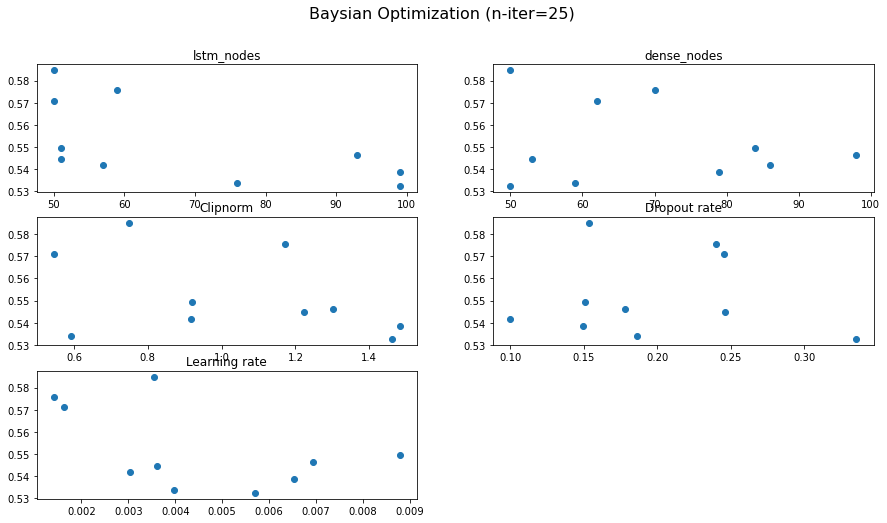

In [10]:
accuracy_list = [i['target'] for i in optimizer.res]
lstm_nodes_list = [int(i['params']['lstm_nodes']) for i in optimizer.res]
dense_nodes_list = [int(i['params']['dense_nodes']) for i in optimizer.res]
clipnorm_list = [i['params']['clipnorm'] for i in optimizer.res]
dropout_rate_list = [i['params']['dropout_rate'] for i in optimizer.res]
lr_list = [i['params']['lr'] for i in optimizer.res]


fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,8))
fig.suptitle('Baysian Optimization (n-iter=25)', fontsize=16)

ax[0][0].scatter(lstm_nodes_list, accuracy_list)
ax[0][0].set_title("lstm_nodes")

ax[0][1].scatter(dense_nodes_list, accuracy_list)
ax[0][1].set_title("dense_nodes")

ax[1][0].scatter(clipnorm_list, accuracy_list)
ax[1][0].set_title('Clipnorm')

ax[1][1].scatter(dropout_rate_list, accuracy_list)
ax[1][1].set_title('Dropout rate')

ax[2][0].scatter(lr_list, accuracy_list)
ax[2][0].set_title('Learning rate');


fig.delaxes(ax[2][1])

It is unclear whether the baysian optimization actually learned something, and we maybe should have used random search instead, which can be even more computationally taxing. For now we use the hyperparameters from the baysian optimization and try to do the full training. 

In [11]:
input_shape = (trainFeatures.shape[1], trainFeatures.shape[2])
batch_size = 4096
useBayesian = True

if useBayesian:
    dropout_rate = baysianOptimum['params']['dropout_rate']
    clipnorm = baysianOptimum['params']['clipnorm']
    lr = baysianOptimum['params']['lr']
    
    lstm_nodes = int(baysianOptimum['params']['lstm_nodes'])
    dense_nodes = int(baysianOptimum['params']['dense_nodes'])
    
    loss_weight = 0.5
else:
    dropout_rate = 0.25
    clipnorm = 0.6
    lr = 0.002
    lstm_nodes = 100
    dense_nodes = 100
    loss_weight = 0.7
    

lstm_model = get_model(input_shape, 
              lstm_nodes,
              lstm_nodes,
              dense_nodes,
              dropout_rate)

opt = Adam(lr=lr, clipnorm=clipnorm)

loss = {
    'Gradient_Prediction': 'mean_squared_error',
    'BuySell_Prediction': 'binary_crossentropy'
    }

metrics = {
    'BuySell_Prediction': 'accuracy'
}

lstm_model.compile(optimizer=opt,
                  loss=loss,
                  metrics=metrics,
                  loss_weights=[loss_weight, 1-loss_weight])

#lstm_model.summary()

## Model training  <a class="anchor" id="Training-vizu">
    
For model training we use the parameters from the baysian optimization and it seems that the model converges after aprox. 1000 epochs. During training we make checkpoints based on the accuracy making sure that we save the weights corresponding with the best performing model based on accuracy on the validation set (early stopping). This is done especially because the loss function is volatile but also to make it so that going forward we are sure to use the best model that were achieved through training.

In [ ]:
## Setup Checkpoints for early stopping
checkpoint_path = 'twoOutputCheckpoints/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

mcp = ModelCheckpoint(checkpoint_path, 
                          monitor='val_BuySell_Prediction_accuracy', 
                          mode='max', 
                          save_best_only=True,
                          save_weights_only=True)

tic()
model_history = lstm_model.fit(trainFeatures, [trainLabel1, trainLabel2],
                               epochs=1000,
                               validation_data = [validationFeatures, [validationLabel1, validationLabel2]],
                               batch_size=batch_size,
                               callbacks=[mcp],
                               verbose=2
                              )
toc()

## Visualization of training step

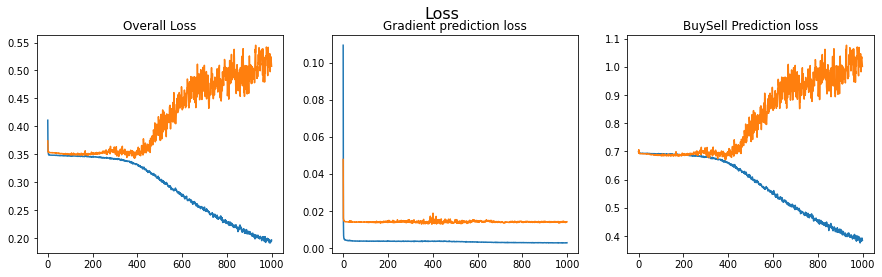

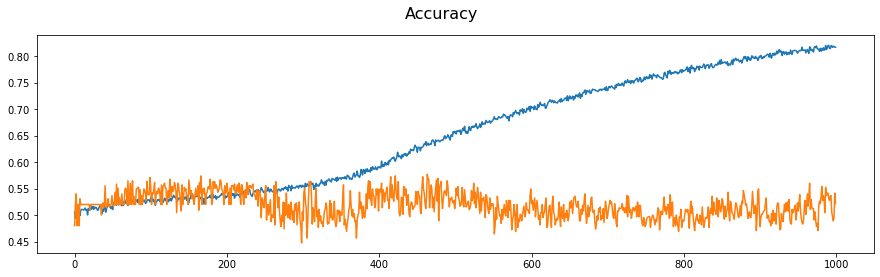

In [13]:
## Loss plots
lossfig, lossaxes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

lossfig.suptitle('Loss', fontsize=16)

lossaxes[0].plot(model_history.history['loss'], label='Training')
lossaxes[0].plot(model_history.history['val_loss'], label='Validation')
lossaxes[0].set_title('Overall Loss')

lossaxes[1].plot(model_history.history['Gradient_Prediction_loss'], label='Training')
lossaxes[1].plot(model_history.history['val_Gradient_Prediction_loss'], label='Validation')
lossaxes[1].set_title('Gradient prediction loss')

lossaxes[2].plot(model_history.history['BuySell_Prediction_loss'], label='Training')
lossaxes[2].plot(model_history.history['val_BuySell_Prediction_loss'], label='Validation')
lossaxes[2].set_title('BuySell Prediction loss')

## Accuracy plot
accfig, accaxes = plt.subplots(nrows=1, ncols=1, figsize=(15,4))

accfig.suptitle('Accuracy', fontsize=16)

accaxes.plot(model_history.history['BuySell_Prediction_accuracy'], label='Training')
accaxes.plot(model_history.history['val_BuySell_Prediction_accuracy'], label='Training');

The model achieve quite high accuracy on the validation training set however looking at the classification loss there seem to be some kind of overfitting going on. One could argue that the error term on the change of the price is not weighing enough on the full loss function and it could be interesting to see the performance if this where changed. The best weights is saved, based on accuracy and for the rest of the notebook it is those weights that will be used.

## Evaluating test data <a class="anchor" id="Test-eval">

To visualize how well the model generalizes we look at the test data.

252/1 - 0s - loss: 0.3898 - Gradient_Prediction_loss: 0.0076 - BuySell_Prediction_loss: 0.7720 - BuySell_Prediction_accuracy: 0.5516


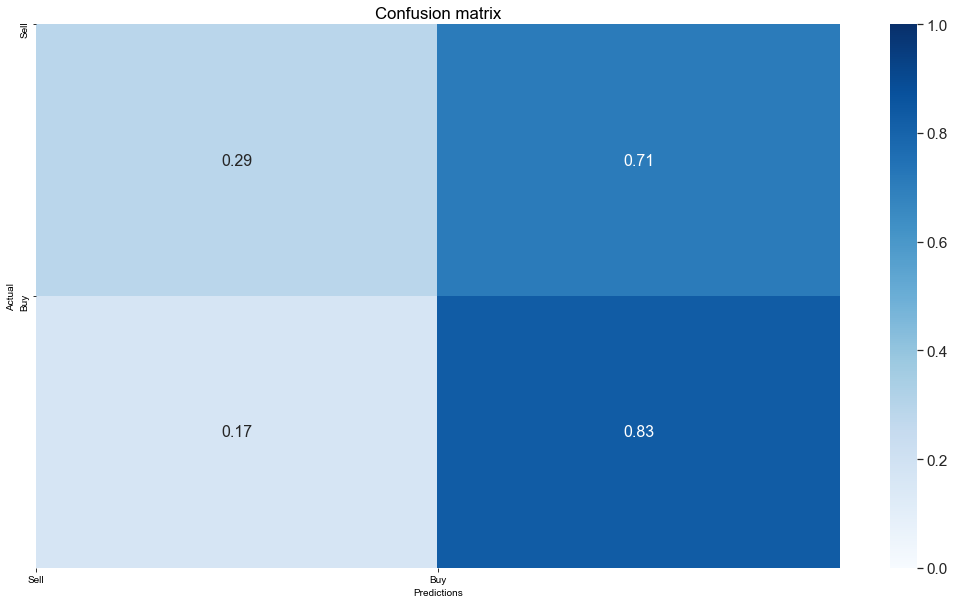

In [14]:
lstm_model.load_weights('twoOutputCheckpoints/cp.ckpt')
lstm_model.evaluate(testFeatures, [testLabel1, testLabel2], verbose=2, batch_size=batch_size)
prediction = lstm_model.predict(testFeatures)

## Confusion matrix
conf_mat = confusion_matrix(testLabel2, (prediction[1] > 0.5), normalize = 'true')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(conf_mat, ax=ax, annot=True, annot_kws={"size": 16}, cmap='Blues', vmin=0, vmax=1) # font size
plt.xticks(ticks=np.arange(2), labels=['Sell', 'Buy'])
plt.yticks(ticks=np.arange(2), labels=['Sell', 'Buy'])
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()

With stock predicting models the accuracy is of course important but the most important is how "right" you are predicting. If the model is quite accurate but when it guess wrong the model is losing a lot the model would not be considered good. So an accuracy of 55% can be okay as long as the model earns money. To see whether the model is actually anything worth we will backtest the model on the test period.

## Backtesting <a class="anchor" id="Backtesting">
To see how the model performs in terms of return we look at the test period and benchmark the algorithm with a passive strategy in the same index. Trading costs is not considered in this backtest which can be a relevant factor especially when the trading frequency is relative high (daily). Typically a passive investment in an index will result in some maintenance cost but these is not considered as well. The testing is done on the period 2020-06-01 to 2020-07-31 (2 months) the tradeoff between test data and training data is always an issue in the sense that you would like as much data for the training the modeling but you also need enough data in the test data to see if the model has not been overfitting.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


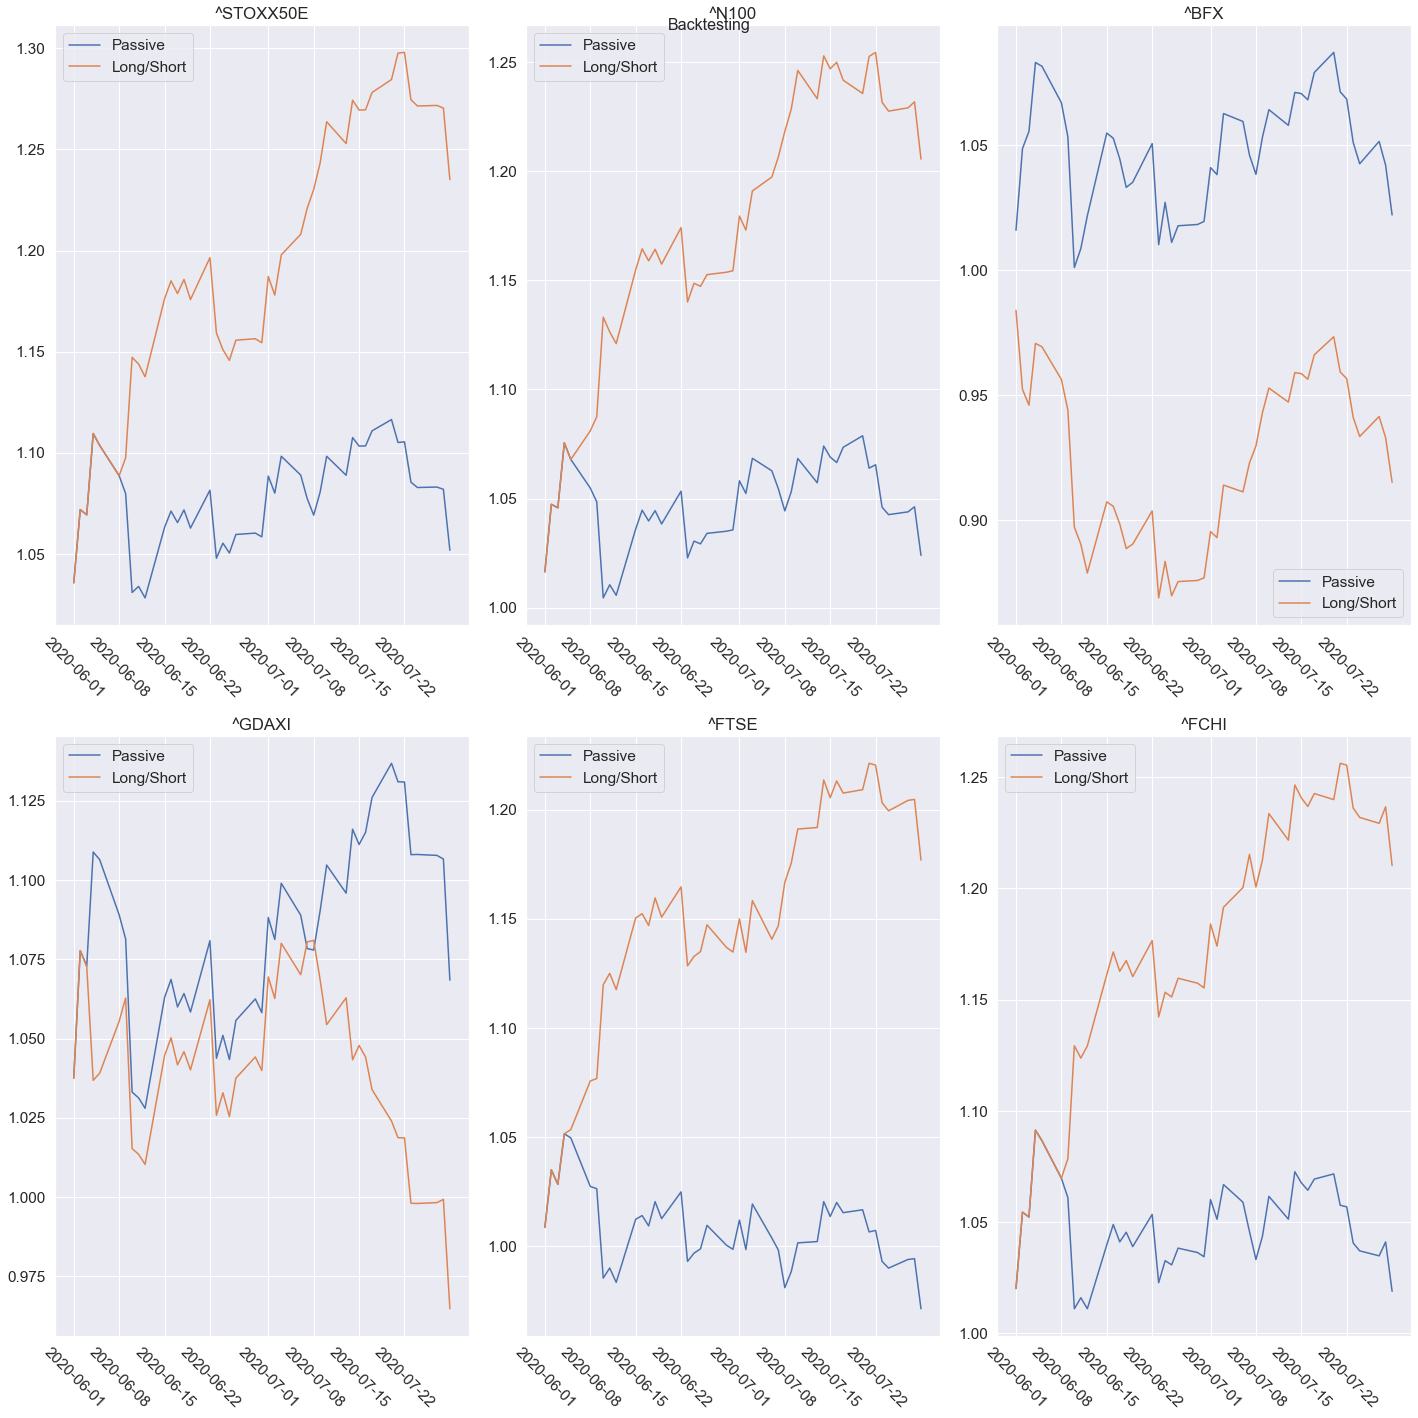

In [65]:
backtestingFig = plt.figure(figsize=(20,20))
backtestingFig.suptitle('Backtesting', fontsize=16)

passiveStrat = dict()
longShortStrat = dict()
excessReturn = dict()

for i, ind in enumerate(indices):
    data = yf.download(ind, start=startDate, end=endDate)
    data = pd.concat([data, curr_vix_data], axis=1)
    data.fillna(method='ffill', inplace=True)
    data.drop(['Volume', 'Adj Close'], axis=1, inplace=True)
    data = addFeatures(data)

    data.loc[:, 'Gradient'] = ((data.loc[:, 'Close'] - data.loc[:, 'Close'].shift())/data.loc[:, 'Close'].shift() + 1).shift(-1)
    data.dropna(inplace=True)
    buySell = data.loc[:, 'Gradient'] > 1 

    ## Normalizing data
    norm_data = scalers[ind].transform(data.to_numpy())
    norm_data = np.append(norm_data, buySell.astype(int).to_numpy().reshape(len(buySell),1), axis=1)

    testFeatures = np.zeros(shape=(0, sequence_length, noOfFeatures))
    testLabel1 = np.zeros(shape=(0,1))
    testLabel2 = np.zeros(shape=(0,1))


    tempFeatures, tempLabel1, tempLabel2 = nnFormat(norm_data,sequence_length)

    testIdx = data.index.get_loc(datetime.datetime.strptime(testDate, '%Y-%m-%d')) - sequence_length

    testFeatures = np.append(testFeatures, tempFeatures[(testIdx-1):,:,:], axis=0)

    prediction = lstm_model.predict(testFeatures)[1] > 0.5
    testData = data.loc[datetime.datetime.strptime(testDate, '%Y-%m-%d'):,["Close", "Gradient"]]
    testData.loc[:,"Prediction"] = prediction
    testData.loc[:, 'BuySell'] = (testData.loc[:,'Prediction']==False).astype(int) * -1 + testData.loc[:,'Prediction'].astype(int)
    testData['LongShortStrat'] = ((testData['Gradient'] - 1) * testData['BuySell'] + 1).cumprod()
    
    passiveStrat[ind] = testData['Gradient'].iloc[-1]
    longShortStrat[ind] = testData['LongShortStrat'].iloc[-1]
    excessReturn[ind] = testData['LongShortStrat'].iloc[-1] - testData['Gradient'].iloc[-1]
    
    ax = backtestingFig.add_subplot(2, 3, i + 1)
    ax.plot(testData['Gradient'].cumprod(), label='Passive')
    ax.plot(testData['LongShortStrat'], label='Long/Short')
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(-45)
    
    ax.set_title(ind)
    ax.legend()

plt.tight_layout()
plt.show()    

In [92]:
## Calculating excess return
print(sum(np.array(list(excessReturn.values())) + 1)/6)
## Actual return
print(sum(longShortStrat.values())/6)

1.1424772603597624
1.1179422855937073


From the graphs we see that the model performs better on some indexes than others. And the excess return is positive as well as the actual return. 

## Conclusion <a class="anchor" id="Conclusion">
So to sum up the well known sequence neural network that is LSTM have shown to be rather well to predict how the stock market moves. During training one could argue that the model seems to overfit based on validation set but nevertheless the accuracy on the test set still in the range of the validation set. And the backtesting of the model with an index that were not used in the training section could argue that the model does indeed learn something that can be used for earning money in the stock market.

It would be possible to set up this as automated trading algorithm if your broker has somekind of API connection and in that case it would perhaps be interesting to look at this model with high frequency data, such as 1 minutte ticks, to see if it will also perform as well in an intra day trading session.
    
Next steps in improving this model would be to look into the overfitting during training. This could be achieved by increasing the epochs during hyperparameter search because as it is now the overfitting happens in range where the hyperparameter search never reaches. 